In [ ]:
# ===================================================================
# CELL 1: Mount Google Drive dan Setup Kaggle
# ===================================================================
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Setup Kaggle credentials
kaggle_json_path = '/content/drive/MyDrive/Kaggle/kaggle.json'

# Buat folder .kaggle di root
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json ke folder yang tepat
!cp "{kaggle_json_path}" /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

print("✓ Google Drive mounted")
print("✓ Kaggle credentials configured")






Mounted at /content/drive
✓ Google Drive mounted
✓ Kaggle credentials configured


In [ ]:
# ===================================================================
# CELL 2: Install Dependencies dan Import Libraries
# ===================================================================
!pip install -q kaggle
!pip install -q torchmetrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix,
    matthews_corrcoef
)
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.4 MB/s eta 0:00:00
✓ All libraries imported successfully


In [ ]:
# ===================================================================
# CELL 3: Download Dataset dari Kaggle
# ===================================================================
# Download dataset
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

# Unzip dataset
!unzip -q melanoma-skin-cancer-dataset-of-10000-images.zip -d melanoma_dataset

print("✓ Dataset downloaded and extracted")

# Cek struktur folder
!ls -la melanoma_dataset/



Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
100% 98.7M/98.7M [00:00<00:00, 220MB/s]
100% 98.7M/98.7M [00:00<00:00, 238MB/s]
✓ Dataset downloaded and extracted
total 12
drwxr-xr-x 3 root root 4096 Dec  5 08:35 .
drwxr-xr-x 1 root root 4096 Dec  5 08:35 ..
drwxr-xr-x 4 root root 4096 Dec  5 08:35 melanoma_cancer_dataset


In [ ]:
# ===================================================================
# CELL 4: Setup Data Preprocessing dan Augmentation
# ===================================================================
# Definisi transformasi untuk training (dengan augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Definisi transformasi untuk testing (tanpa augmentasi)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✓ Data transformations defined")




✓ Data transformations defined


In [ ]:
# ===================================================================
# CELL 5: Load Dataset dengan ImageFolder
# ===================================================================
# Sesuaikan path dengan struktur dataset Anda
# Biasanya dataset Kaggle ini memiliki folder train dan test
train_data_path = 'melanoma_dataset/melanoma_cancer_dataset/train'  # Sesuaikan dengan struktur folder
test_data_path = 'melanoma_dataset/melanoma_cancer_dataset/test'    # Sesuaikan dengan struktur folder

# Load datasets
train_dataset = ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_data_path, transform=test_transforms)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Testing samples: {len(test_dataset)}")
print(f"✓ Classes: {train_dataset.classes}")
print(f"✓ Class to index mapping: {train_dataset.class_to_idx}")




✓ Training samples: 9605
✓ Testing samples: 1000
✓ Classes: ['benign', 'malignant']
✓ Class to index mapping: {'benign': 0, 'malignant': 1}


In [ ]:
# ===================================================================
# CELL 6: Create Data Loaders
# ===================================================================
# Parameter yang umum digunakan (karena tidak disebutkan di paper)
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")




✓ Train batches: 301
✓ Test batches: 32


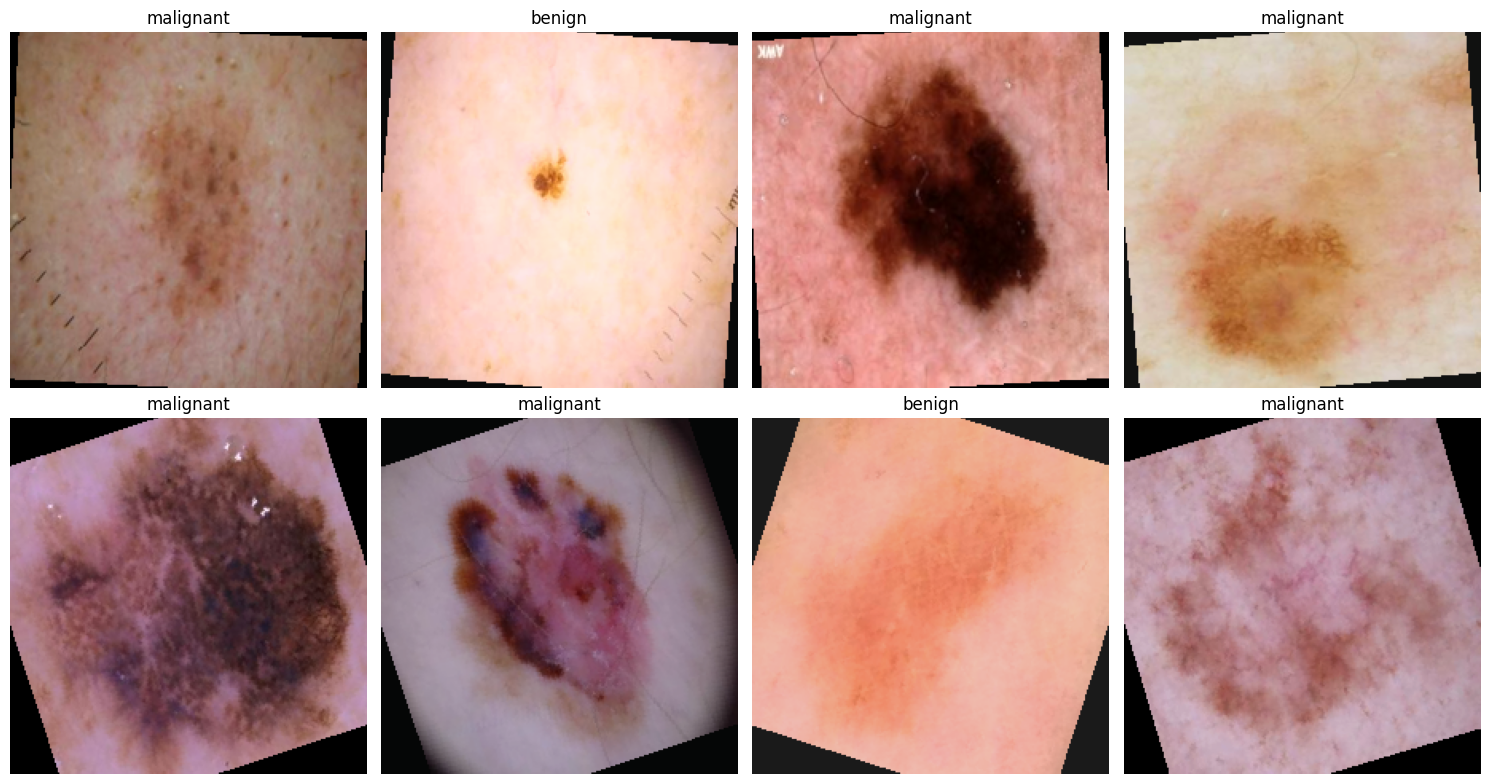

In [ ]:
# ===================================================================
# CELL 7: Visualisasi Sample Data
# ===================================================================
def imshow(img, title):
    """Denormalisasi dan tampilkan gambar"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Ambil batch pertama
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Tampilkan 8 gambar pertama
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    plt.sca(ax)
    class_name = train_dataset.classes[labels[idx]]
    imshow(images[idx], f'{class_name}')
plt.tight_layout()
plt.show()




In [ ]:
# ===================================================================
# CELL 8: Define EfficientNet-B0 Model
# ===================================================================
import torch
import torch.nn as nn
from torchvision import models

class MelanomaEfficientNetB0(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(MelanomaEfficientNetB0, self).__init__()

        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

        # Ambil jumlah fitur dari classifier bawaan
        num_features = self.efficientnet.classifier[1].in_features

        # Modifikasi classifier sesuai struktur paper
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)


# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Inisialisasi model
model = MelanomaEfficientNetB0(num_classes=2, pretrained=True)
model = model.to(device)

print("✓ EfficientNet-B0 model initialized")
print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")


✓ Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 94.9MB/s]


✓ EfficientNet-B0 model initialized
✓ Total parameters: 13,353,526


In [ ]:
# ===================================================================
# CELL 9: Define Loss Function dan Optimizer
# ===================================================================
# Parameter training (disesuaikan karena tidak ada di paper)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
WEIGHT_DECAY = 1e-4

# Loss function untuk binary classification
criterion = nn.CrossEntropyLoss()

# Optimizer (menggunakan Adam sebagai default)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("✓ Loss function and optimizer configured")




✓ Loss function and optimizer configured


In [ ]:
# ===================================================================
# CELL 10: Training Function
# ===================================================================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 50 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc





In [ ]:
# ===================================================================
# CELL 11: Validation/Test Function
# ===================================================================
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            running_loss += loss.item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilitas kelas positif

    epoch_loss = running_loss / len(test_loader)

    return epoch_loss, all_predictions, all_labels, all_probs




In [ ]:
# ===================================================================
# CELL 12: Main Training Loop
# ===================================================================
# History untuk tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
    print('-' * 60)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
    val_acc = 100. * accuracy_score(val_labels, val_preds)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'\nEpoch Summary:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientnetb0_melanoma.pth')
        print(f'  ✓ New best model saved! (Acc: {best_val_acc:.2f}%)')

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")



Epoch [1/100]
------------------------------------------------------------
  Batch [50/301], Loss: 0.1415, Acc: 85.25%
  Batch [100/301], Loss: 0.2738, Acc: 86.94%
  Batch [150/301], Loss: 0.2563, Acc: 88.48%
  Batch [200/301], Loss: 0.1637, Acc: 88.94%
  Batch [250/301], Loss: 0.1619, Acc: 88.92%
  Batch [300/301], Loss: 0.1935, Acc: 89.11%

Epoch Summary:
  Train Loss: 0.2804, Train Acc: 89.11%
  Val Loss: 0.3109, Val Acc: 90.40%
  ✓ New best model saved! (Acc: 90.40%)

Epoch [2/100]
------------------------------------------------------------
  Batch [50/301], Loss: 0.3050, Acc: 89.88%
  Batch [100/301], Loss: 0.1964, Acc: 89.81%
  Batch [150/301], Loss: 0.1176, Acc: 90.31%
  Batch [200/301], Loss: 0.3676, Acc: 90.41%
  Batch [250/301], Loss: 0.1370, Acc: 90.61%
  Batch [300/301], Loss: 0.4318, Acc: 90.59%

Epoch Summary:
  Train Loss: 0.2474, Train Acc: 90.58%
  Val Loss: 0.2629, Val Acc: 90.30%

Epoch [3/100]
------------------------------------------------------------
  Batch [5

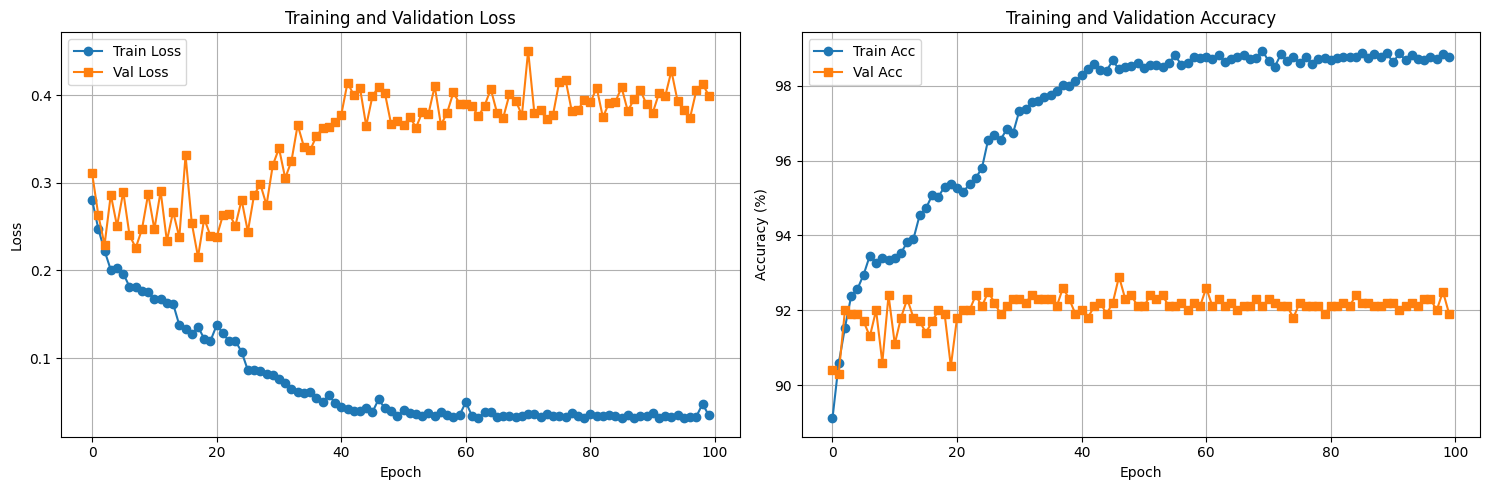

In [ ]:
# ===================================================================
# CELL 13: Plot Training History
# ===================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# CELL 14: Load Best Model dan Final Evaluation
# ===================================================================
# Load best model
model.load_state_dict(torch.load('best_efficientnetb0_melanoma.pth'))
print("✓ Best model loaded")

# Final evaluation
_, final_preds, final_labels, final_probs = evaluate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)

✓ Best model loaded

FINAL EVALUATION RESULTS


In [ ]:
from sklearn.metrics import classification_report

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(final_labels, final_preds).ravel()

# Calculate metrics sesuai paper
accuracy = accuracy_score(final_labels, final_preds) * 100
sensitivity = recall_score(final_labels, final_preds) * 100  # Recall
specificity = (tn / (tn + fp)) * 100
precision = precision_score(final_labels, final_preds) * 100
f1 = f1_score(final_labels, final_preds) * 100
mcc = matthews_corrcoef(final_labels, final_preds) * 100
geometric_mean = np.sqrt(sensitivity * specificity)
error_rate = (1 - accuracy/100) * 100
type1_error = (fp / (fp + tn)) * 100  # False Positive Rate
type2_error = (fn / (fn + tp)) * 100  # False Negative Rate

# ROC Curve dan AUC
fpr, tpr, _ = roc_curve(final_labels, final_probs)
roc_auc = auc(fpr, tpr) * 100

print("\nPerformance Metrics (Target: EfficientNet-B0 Paper)")
print("-" * 60)
print(f"Accuracy:              {accuracy:.2f}%")
print(f"Sensitivity (Recall):  {sensitivity:.2f}%")
print(f"Specificity:           {specificity:.2f}%")
print(f"Precision:             {precision:.2f}%")
print(f"F1-Score:              {f1:.2f}%")
print(f"MCC:                   {mcc:.2f}%")
print(f"Geometric Mean:        {geometric_mean:.2f}%")
print(f"Error Rate:            {error_rate:.2f}%")
print(f"Type-I Error (FP):     {type1_error:.2f}%")
print(f"Type-II Error (FN):    {type2_error:.2f}%")
print(f"AUC:                   {roc_auc:.2f}%")

print("\nConfusion Matrix:")
print(f"  TN: {tn}, FP: {fp}")
print(f"  FN: {fn}, TP: {tp}")


Performance Metrics (Target: EfficientNet-B0 Paper)
------------------------------------------------------------
Accuracy:              92.90%
Sensitivity (Recall):  92.80%
Specificity:           93.00%
Precision:             92.99%
F1-Score:              92.89%
MCC:                   85.80%
Geometric Mean:        92.90%
Error Rate:            7.10%
Type-I Error (FP):     7.00%
Type-II Error (FN):    7.20%
AUC:                   97.90%

Confusion Matrix:
  TN: 465, FP: 35
  FN: 36, TP: 464


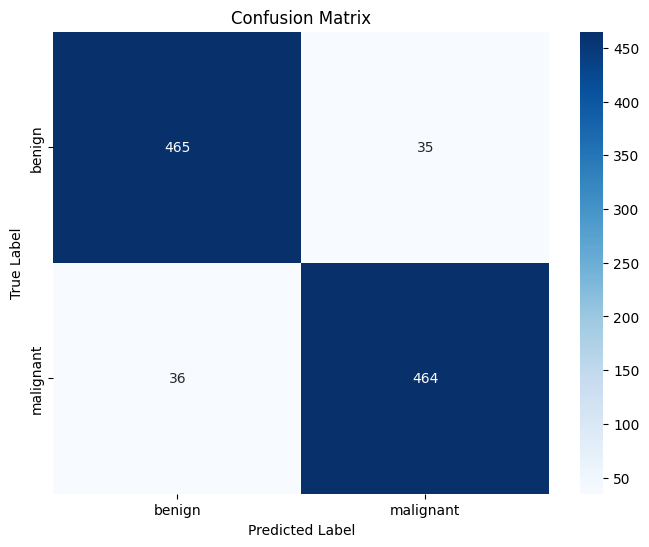

In [ ]:
# ===================================================================
# CELL 16: Visualisasi Confusion Matrix
# ===================================================================
cm = confusion_matrix(final_labels, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

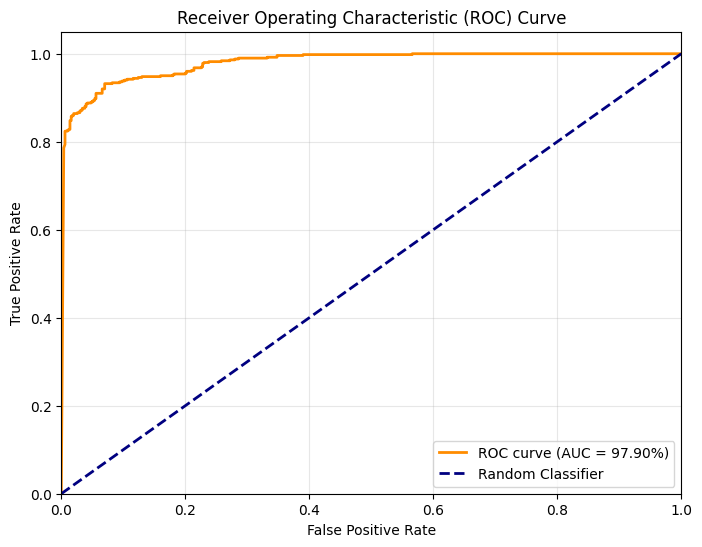

In [ ]:
# ===================================================================
# CELL 17: Plot ROC Curve
# ===================================================================
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ===================================================================
# CELL 18: Classification Report Detail
# ===================================================================
print("\nDetailed Classification Report:")
print("="*60)
print(classification_report(
    final_labels,
    final_preds,
    target_names=train_dataset.classes,
    digits=4
))


Detailed Classification Report:
              precision    recall  f1-score   support

      benign     0.9281    0.9300    0.9291       500
   malignant     0.9299    0.9280    0.9289       500

    accuracy                         0.9290      1000
   macro avg     0.9290    0.9290    0.9290      1000
weighted avg     0.9290    0.9290    0.9290      1000



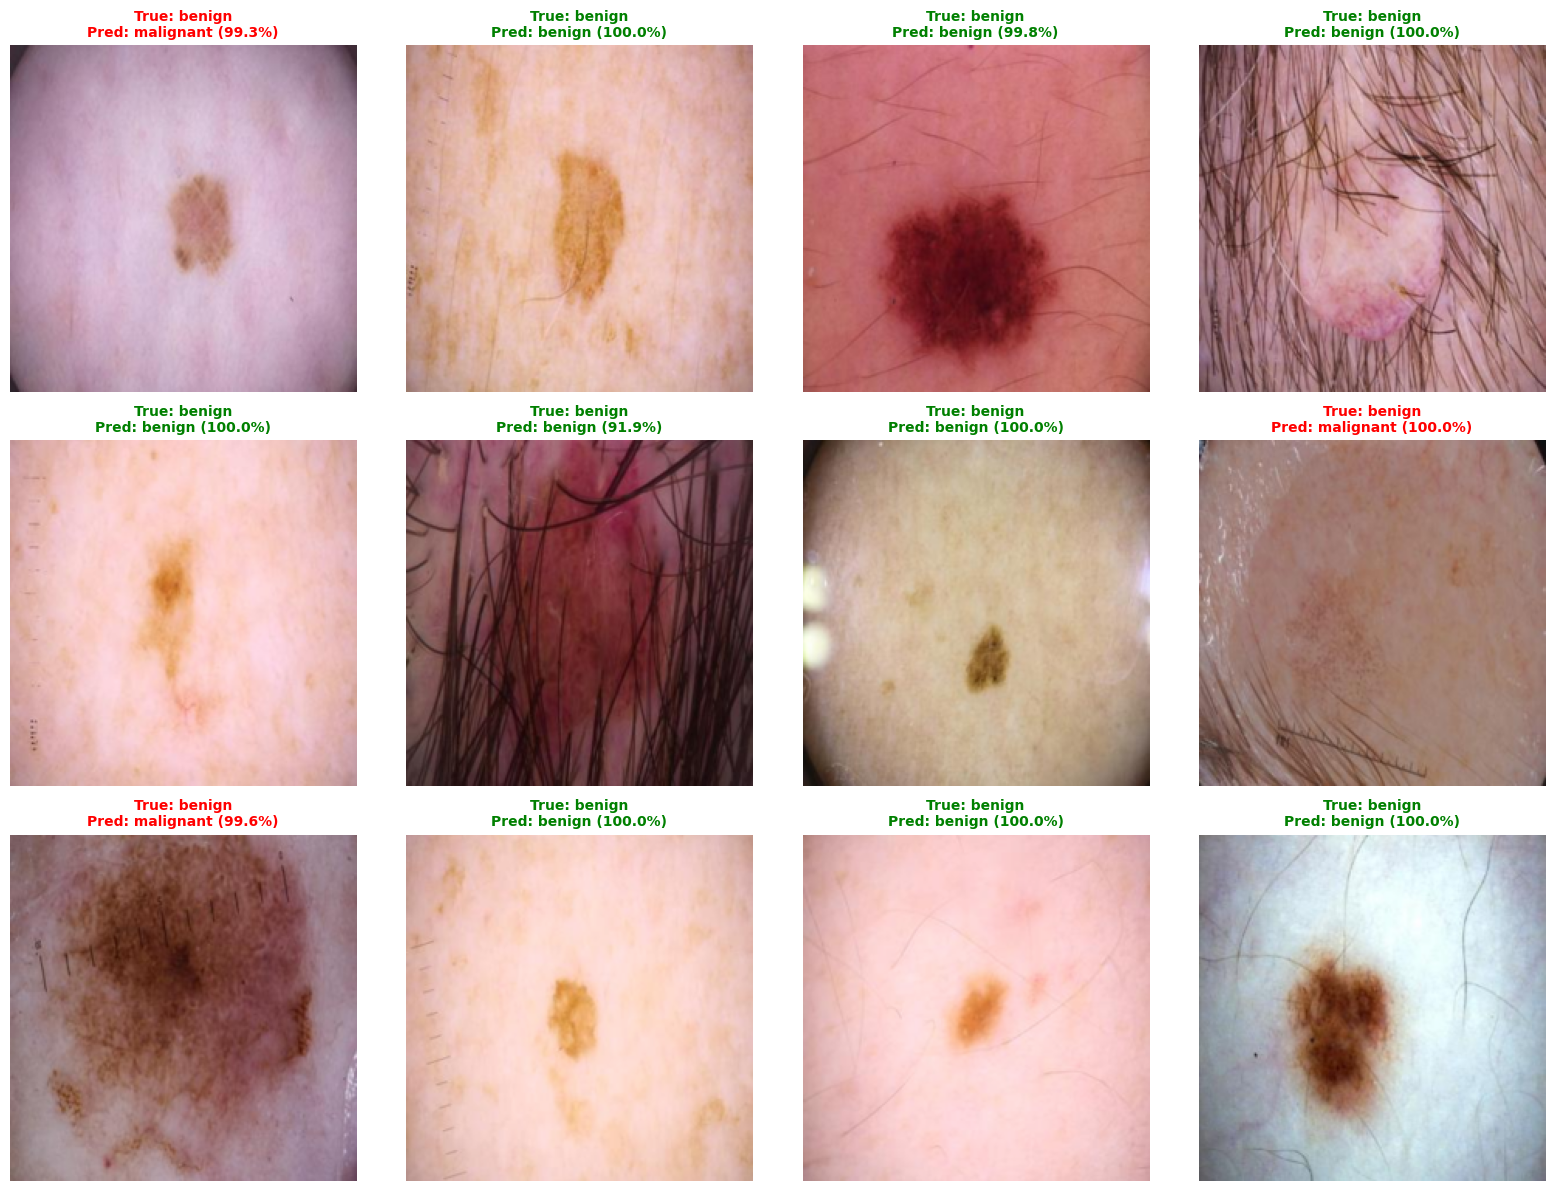

✓ Final model saved as 'efficientnetb0_melanoma_final.pth'
✓ Models copied to Google Drive

PROJECT COMPLETED!


In [ ]:
# ===================================================================
# CELL 19: Visualisasi Prediksi Sample
# ===================================================================
def visualize_predictions(model, test_loader, device, num_images=12):
    model.eval()

    # Ambil satu batch
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Prediksi
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Plot
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx in range(min(num_images, len(images))):
        ax = axes[idx // 4, idx % 4]

        # Denormalisasi gambar
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        true_label = train_dataset.classes[labels[idx]]
        pred_label = train_dataset.classes[predicted[idx]]
        confidence = probs[idx][predicted[idx]].item() * 100

        color = 'green' if predicted[idx] == labels[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                    color=color, fontsize=10, weight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device, num_images=12)


# ===================================================================
# CELL 20: Save Model dan Summary
# ===================================================================
# Save final model
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'history': history
}, 'efficientnetb0_melanoma_final.pth')

print("✓ Final model saved as 'efficientnetb0_melanoma_final.pth'")

# Save ke Google Drive
!cp best_efficientnetb0_melanoma.pth /content/drive/MyDrive/Kaggle/
!cp efficientnetb0_melanoma_final.pth /content/drive/MyDrive/Kaggle/

print("✓ Models copied to Google Drive")
print("\n" + "="*60)
print("PROJECT COMPLETED!")
print("="*60)